In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [2]:
df = pd.read_csv('C:/Users/moham/Desktop/itemFive.csv')
df

,date,store,item,sales
0,15/01/13,1,5,863
1,15/02/13,1,5,198
2,15/03/13,1,5,718
3,15/04/13,1,5,804
4,15/05/13,1,5,589
...,...,...,...,...
122,15/03/23,1,5,916
123,15/04/23,1,5,640
124,15/05/23,1,5,734
125,15/06/23,1,5,579


In [3]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [4]:
# Filter records for store 1 and item 1 -> to be able to scale to other items in the future
df = df[df['store'] == 1]
df = df[df['item'] == 5]

df['date'] = pd.to_datetime(df['date'], format='%d/%m/%y')

# Create Date-related Features for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df['weekday'] == 0, 7, df['weekday'])

# Split the series for prediction
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2021-12-31']                         
test_df = temp_df.loc['2022-01-01':]

train_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2013-01-15,1,5,863,2013,1,15,1
2013-02-15,1,5,198,2013,2,15,4
2013-03-15,1,5,718,2013,3,15,4
2013-04-15,1,5,804,2013,4,15,7
2013-05-15,1,5,589,2013,5,15,2


In [5]:
test_df.head()

,store,item,sales,year,month,day,weekday
date,,,,,,,
2022-01-15,1,5,47,2022,1,15,5
2022-02-15,1,5,974,2022,2,15,1
2022-03-15,1,5,283,2022,3,15,1
2022-04-15,1,5,522,2022,4,15,4
2022-05-15,1,5,715,2022,5,15,6


In [6]:
reg_df = df
reg_df

,date,store,item,sales,year,month,day,weekday
0,2013-01-15,1,5,863,2013,1,15,1
1,2013-02-15,1,5,198,2013,2,15,4
2,2013-03-15,1,5,718,2013,3,15,4
3,2013-04-15,1,5,804,2013,4,15,7
4,2013-05-15,1,5,589,2013,5,15,2
...,...,...,...,...,...,...,...,...
122,2023-03-15,1,5,916,2023,3,15,2
123,2023-04-15,1,5,640,2023,4,15,5
124,2023-05-15,1,5,734,2023,5,15,7
125,2023-06-15,1,5,579,2023,6,15,3


In [7]:
# Lag features
for i in range(1,8):
    lag_i = 'lag_' + str(i)
    reg_df[lag_i] = reg_df.sales.shift(i)
    
# Rolling window
reg_df['rolling_mean'] = reg_df.sales.rolling(window=7).mean()
reg_df['rolling_max'] = reg_df.sales.rolling(window=7).max()
reg_df['rolling_min'] = reg_df.sales.rolling(window=7).min()

reg_df = reg_df.dropna(how='any', inplace=False)
reg_df = reg_df.drop(['store', 'item'], axis=1)

# Split the series to predict 
reg_df = reg_df.set_index('date')
reg_train_df = reg_df.loc[:'2021-12-31']                        
reg_test_df = reg_df.loc['2022-01-01':]

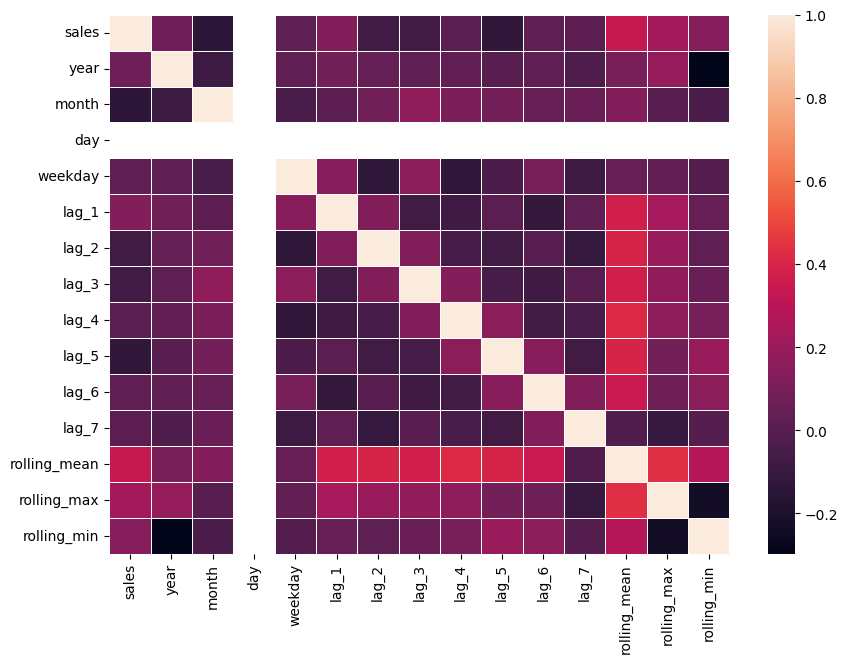

In [8]:
# Correlation matrix with heatmap
corr = reg_train_df.corr()
fig = plt.figure(figsize=(10,7))
_ = sn.heatmap(corr, linewidths=.5)

In [9]:
X_train = reg_train_df.drop(['sales'], axis=1)
y_train = reg_train_df['sales'].values

X_test = reg_test_df.drop(['sales'], axis=1)
y_test = reg_test_df['sales'].values

#Univariate SelectKBest class to extract top 5 best features
top_features = SelectKBest(score_func=f_regression, k=5)
fit = top_features.fit(X_train, y_train)
df_scores = pd.DataFrame(fit.scores_)
df_columns = pd.DataFrame(X_train.columns)

#concat two dataframes for better visualization 
feature_scores = pd.concat([df_columns, df_scores], axis=1)
feature_scores.columns = ['Feature','Score']  # naming the dataframe columns
print(feature_scores.nlargest(5,'Score'))  # print 5 best features

         Feature      Score
11  rolling_mean  12.987070
12   rolling_max   5.468846
1          month   2.179898
13   rolling_min   2.066040
4          lag_1   1.770719


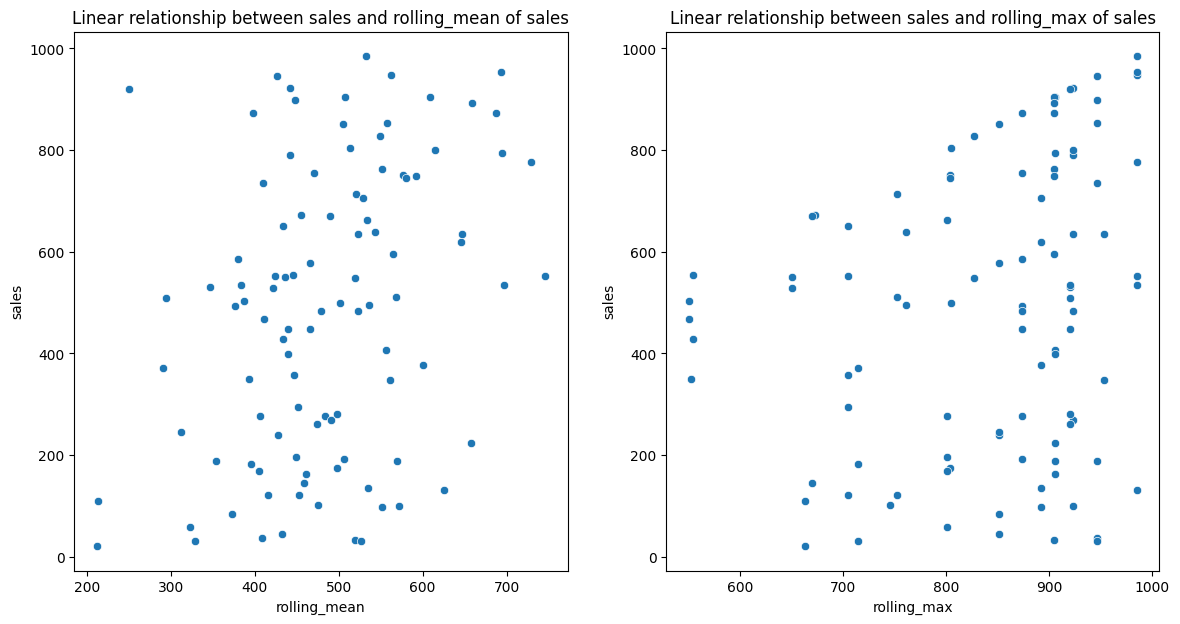

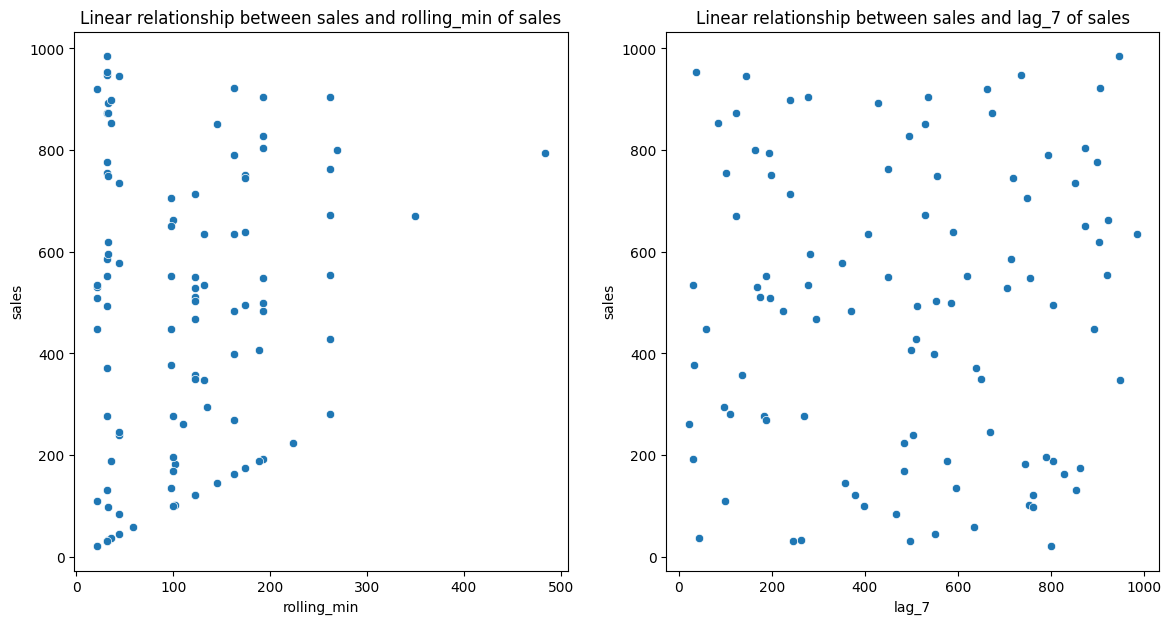

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(x=reg_train_df.rolling_mean, y=reg_train_df.sales, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_mean of sales')
sn.scatterplot(x=reg_train_df.rolling_max, y=reg_train_df.sales, ax=axs[1])
axs[1].set(title='Linear relationship between sales and rolling_max of sales')

fig, axs = plt.subplots(ncols=2, figsize=(14,7))
sn.scatterplot(x=reg_train_df.rolling_min, y=reg_train_df.sales, ax=axs[0])
axs[0].set(title='Linear relationship between sales and rolling_min of sales')
sn.scatterplot(x=reg_train_df.lag_7, y=reg_train_df.sales, ax=axs[1])
_ = axs[1].set(title='Linear relationship between sales and lag_7 of sales')

In [11]:
# update X_train, X_test to include top features
X_train = X_train[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]
X_test = X_test[['rolling_mean', 'rolling_max', 'rolling_min', 'lag_7', 'lag_1']]

# fit model
model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)

errors_df = reg_test_df[['sales']]
errors_df['pred_sales'] = preds
errors_df['errors'] = preds - y_test
errors_df.insert(0, 'model', 'LinearRegression')

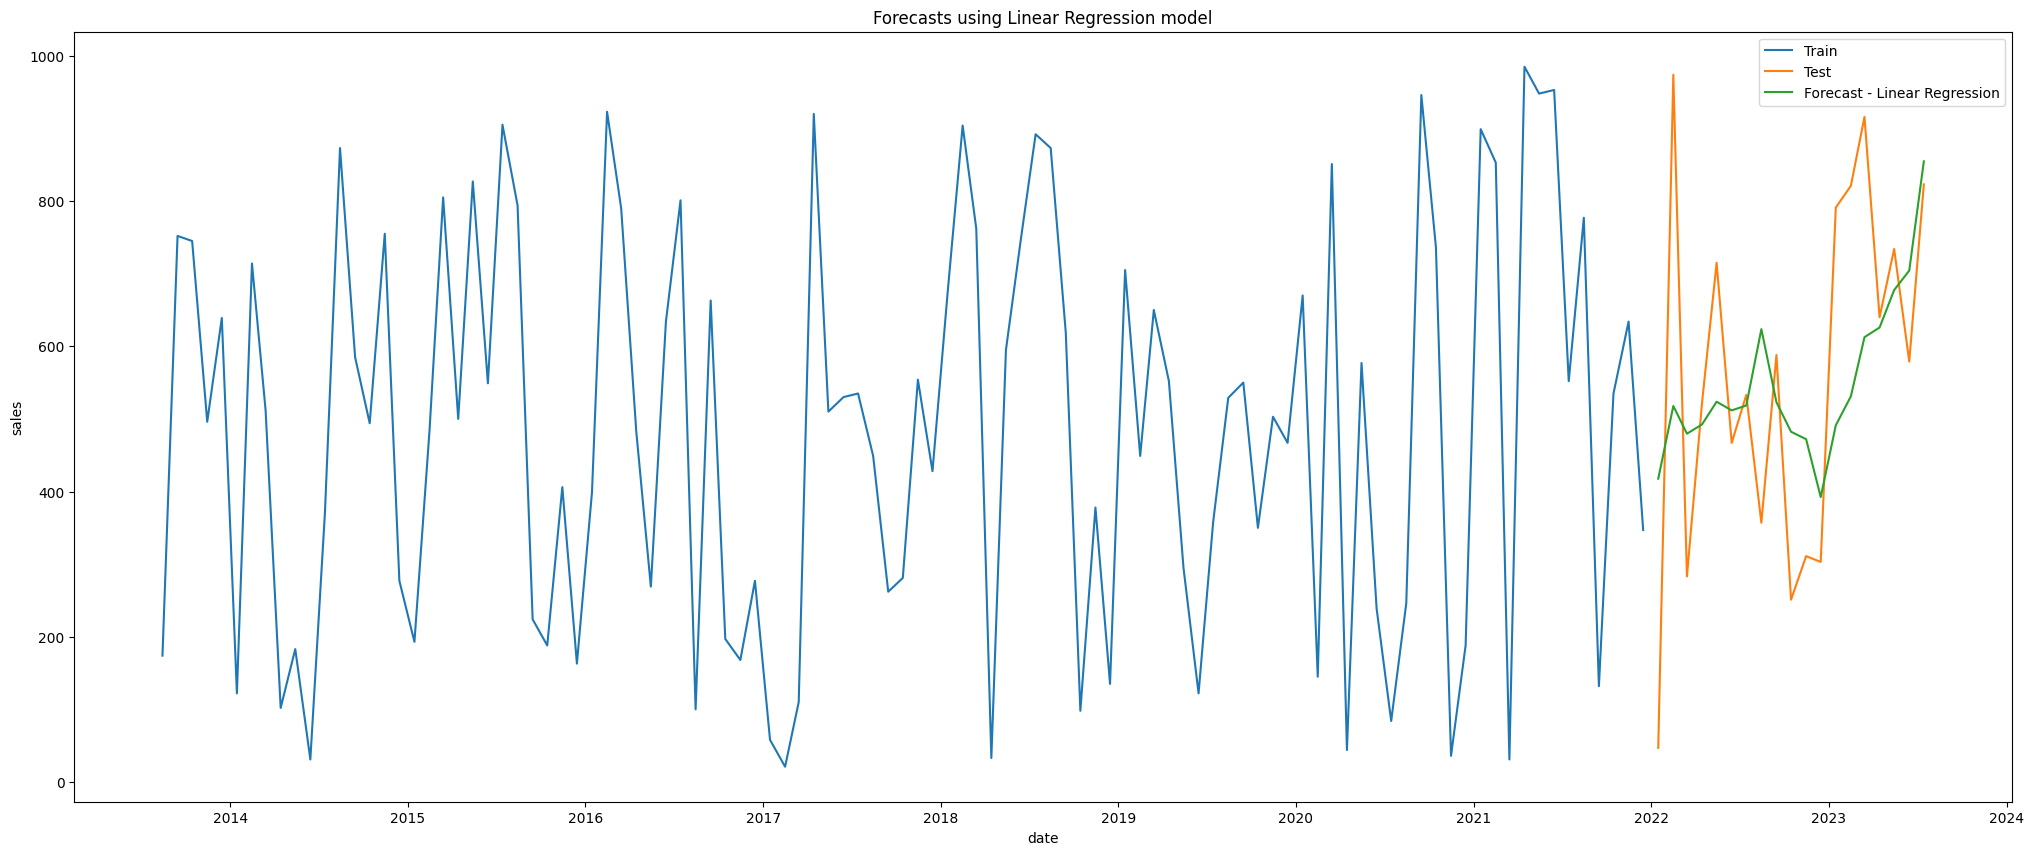

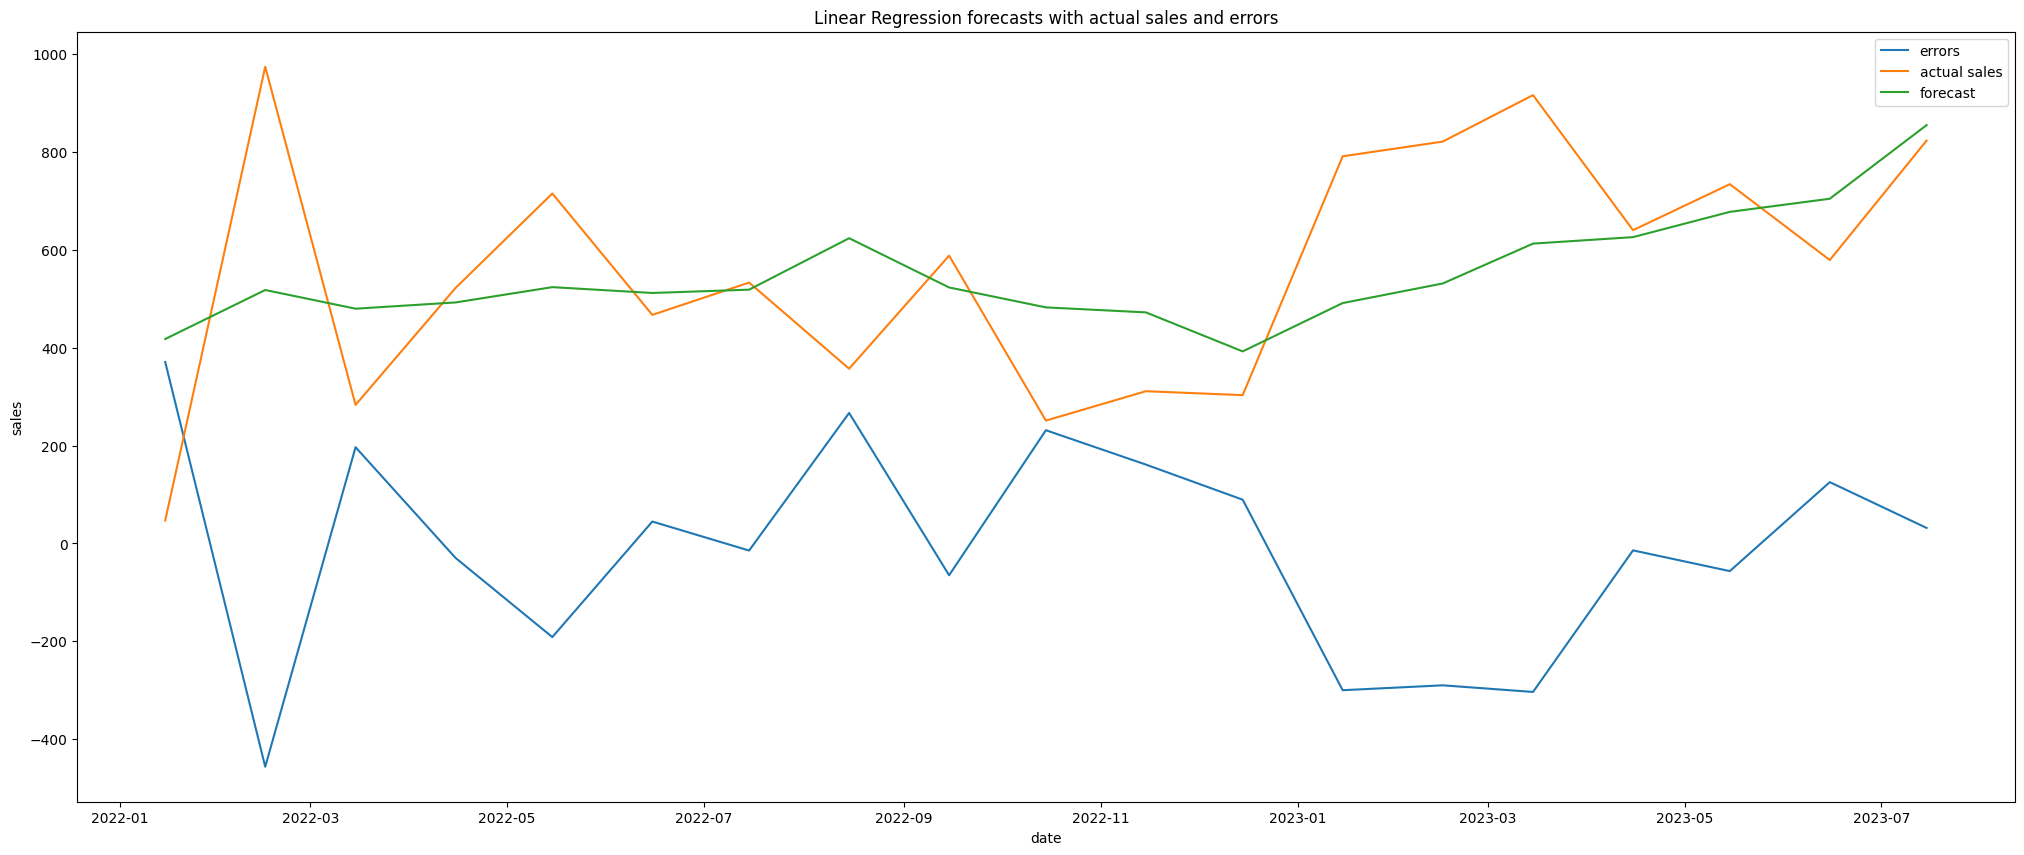

,total_sales,total_pred_sales,LR_overall_error,MAE,RMSE,MAPE
model,,,,,,
LinearRegression,10655,10451.636071,-203.363929,170.421005,214.32811,71.088111


In [12]:
# Import necessary libraries
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error
from math import sqrt

# Define RMSE function
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# Define MAPE function
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# eval predictions
fig = plt.figure(figsize=(25,10))
plt.plot(reg_train_df.index, reg_train_df['sales'], label='Train')
plt.plot(reg_test_df.index, reg_test_df['sales'], label='Test')
plt.plot(errors_df.index, errors_df['pred_sales'], label='Forecast - Linear Regression')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Linear Regression model')
plt.show()

fig = plt.figure(figsize=(25,10))
plt.plot(errors_df.index, errors_df.errors, label='errors')
plt.plot(errors_df.index, errors_df.sales, label='actual sales')
plt.plot(errors_df.index, errors_df.pred_sales, label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Linear Regression forecasts with actual sales and errors')
plt.show()

# Calculate errors for each model
errors_df['mae'] = mae(errors_df['sales'], errors_df['pred_sales'])
errors_df['rmse'] = rmse(errors_df['sales'], errors_df['pred_sales'])
errors_df['mape'] = mape(errors_df['sales'], errors_df['pred_sales'])

# Now you can aggregate
result_df_lr = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                          total_pred_sales=('pred_sales', 'sum'),
                                          LR_overall_error=('errors', 'sum'),
                                          MAE=('mae', 'mean'),
                                          RMSE=('rmse', 'mean'), 
                                          MAPE=('mape', 'mean'))
result_df_lr